In [ ]:
import zipfile
import os

# 압축 파일 경로 및 해제할 폴더 경로 설정
zip_file_path = '/content/찐막.zip'
extract_dir = '/content/uploadfolder'  # 압축 해제할 폴더 경로

# 압축 파일이 존재하는지 확인
if os.path.exists(zip_file_path):
    print(f"'{zip_file_path}' 파일을 찾았습니다.")

    # 압축을 풀 폴더가 없으면 생성
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
        print(f"'{extract_dir}' 폴더를 생성했습니다.")

    # zipfile 라이브러리를 사용하여 압축 해제
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"'{zip_file_path}' 압축을 '{extract_dir}'에 성공적으로 해제했습니다.")
else:
    print(f"'{zip_file_path}' 파일을 찾을 수 없습니다. 경로를 확인하세요.")

'/content/찐막.zip' 파일을 찾았습니다.
'/content/uploadfolder' 폴더를 생성했습니다.
'/content/찐막.zip' 압축을 '/content/uploadfolder'에 성공적으로 해제했습니다.


In [ ]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from collections import Counter

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
base_dir = './uploadfolder'  # 베이스 경로 (압축을 푼 폴더 경로)
batch_size = 16

# 통합된 train 및 valid 폴더 경로 설정
train_dir = os.path.join(base_dir, '찐막', 'train')
valid_dir = os.path.join(base_dir, '찐막', 'valid')

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(train_dir, transform=transform)
valid_dataset = CustomDataset(valid_dir, transform=transform)

# train 데이터셋이 비어있는지 확인
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty. Check if the images are correctly loaded.")

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# 샘플 가중치가 비어있는지 확인
if len(sample_weights) == 0:
    raise ValueError("Sample weights are empty. Check the dataset loading process.")

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.3으로 설정)
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Dropout 비율을 0.3으로 조정
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 감소)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    print(f'Validation Accuracy: {valid_accuracy}%')

    # Early Stopping 기준
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 163MB/s]
Epoch 1/30: 100%|██████████| 25/25 [04:34<00:00, 10.98s/it, loss=0.628]


Epoch 1/30, Loss: 0.6281898951530457, Train Accuracy: 65.80976863753213%
Validation Accuracy: 61.72839506172839%


Epoch 2/30: 100%|██████████| 25/25 [04:15<00:00, 10.24s/it, loss=0.494]


Epoch 2/30, Loss: 0.4935920667648315, Train Accuracy: 81.49100257069409%
Validation Accuracy: 67.90123456790124%


Epoch 3/30: 100%|██████████| 25/25 [04:14<00:00, 10.19s/it, loss=0.373]


Epoch 3/30, Loss: 0.372517032623291, Train Accuracy: 86.11825192802057%
Validation Accuracy: 70.37037037037037%


Epoch 4/30: 100%|██████████| 25/25 [04:14<00:00, 10.17s/it, loss=0.351]


Epoch 4/30, Loss: 0.35121143341064454, Train Accuracy: 83.80462724935732%
Validation Accuracy: 74.07407407407408%


Epoch 5/30: 100%|██████████| 25/25 [04:14<00:00, 10.20s/it, loss=0.237]


Epoch 5/30, Loss: 0.2366143596172333, Train Accuracy: 90.74550128534705%
Validation Accuracy: 74.07407407407408%


Epoch 6/30: 100%|██████████| 25/25 [04:14<00:00, 10.18s/it, loss=0.252]


Epoch 6/30, Loss: 0.25178828299045564, Train Accuracy: 92.2879177377892%
Validation Accuracy: 80.24691358024691%


Epoch 7/30: 100%|██████████| 25/25 [04:14<00:00, 10.18s/it, loss=0.155]


Epoch 7/30, Loss: 0.15467578411102295, Train Accuracy: 95.62982005141389%
Validation Accuracy: 70.37037037037037%


Epoch 8/30: 100%|██████████| 25/25 [04:14<00:00, 10.19s/it, loss=0.175]


Epoch 8/30, Loss: 0.17509734980762004, Train Accuracy: 92.80205655526993%
Validation Accuracy: 83.95061728395062%


Epoch 9/30: 100%|██████████| 25/25 [04:14<00:00, 10.18s/it, loss=0.147]


Epoch 9/30, Loss: 0.14662971943616868, Train Accuracy: 95.11568123393316%
Validation Accuracy: 82.71604938271605%


Epoch 10/30: 100%|██████████| 25/25 [04:14<00:00, 10.20s/it, loss=0.132]


Epoch 10/30, Loss: 0.132050226777792, Train Accuracy: 96.1439588688946%
Validation Accuracy: 72.8395061728395%


Epoch 11/30: 100%|██████████| 25/25 [04:15<00:00, 10.20s/it, loss=0.078]


Epoch 11/30, Loss: 0.07799242924898862, Train Accuracy: 97.4293059125964%
Validation Accuracy: 80.24691358024691%


Epoch 12/30: 100%|██████████| 25/25 [04:14<00:00, 10.16s/it, loss=0.096]


Epoch 12/30, Loss: 0.09595256138592959, Train Accuracy: 96.91516709511568%
Validation Accuracy: 81.48148148148148%


Epoch 13/30: 100%|██████████| 25/25 [04:14<00:00, 10.18s/it, loss=0.0813]


Epoch 13/30, Loss: 0.08129486303776502, Train Accuracy: 97.17223650385604%
Validation Accuracy: 76.54320987654322%
Early stopping 적용


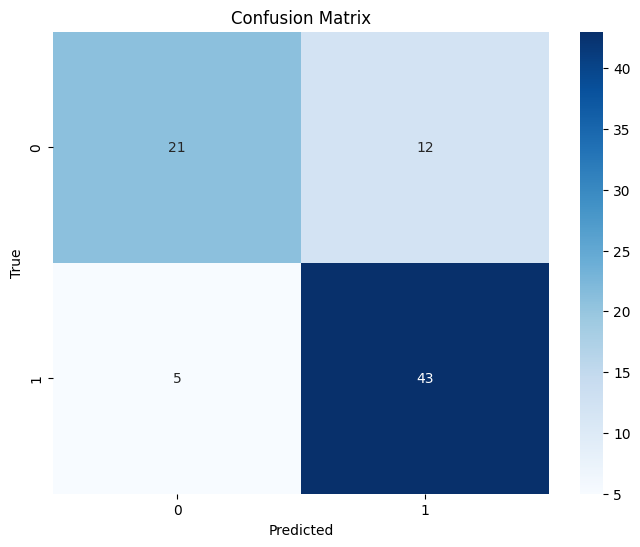

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 모델이 예측한 결과와 실제 라벨을 기반으로 혼동 행렬 계산
def calculate_confusion_matrix(model, dataloader, device):
    model.eval()  # 평가 모드로 전환
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # 그래디언트 계산 비활성화 (추론 모드)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())  # 실제 라벨
            pred_labels.extend(predicted.cpu().numpy())  # 예측된 라벨

    # 혼동 행렬 계산
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

# 혼동 행렬 시각화
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 예시: 모델 평가 및 혼동 행렬 계산
cm = calculate_confusion_matrix(model, valid_loader, device)

# 클래스 이름 예시 (0, 1로 구분되는 경우)
class_names = ['0', '1']

# 혼동 행렬 시각화
plot_confusion_matrix(cm, class_names)


In [ ]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F  # 이 부분을 추가

from collections import Counter

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# Focal Loss 함수 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')  # torch.nn.functional에서 가져오는 cross_entropy
        pt = torch.exp(-BCE_loss)  # 예측 확률
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# 경로 및 배치 크기 설정
base_dir = './uploadfolder'  # 베이스 경로 (압축을 푼 폴더 경로)
batch_size = 16

# 통합된 train 및 valid 폴더 경로 설정
train_dir = os.path.join(base_dir, '찐막', 'train')
valid_dir = os.path.join(base_dir, '찐막', 'valid')

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(train_dir, transform=transform)
valid_dataset = CustomDataset(valid_dir, transform=transform)

# train 데이터셋이 비어있는지 확인
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty. Check if the images are correctly loaded.")

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights
weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Focal Loss 적용
criterion = FocalLoss(alpha=1, gamma=2)

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 감소)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# 학습 과정
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # 검증 평가
    model.eval()
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    print(f'Validation Accuracy: {valid_accuracy}%')

    # Early Stopping 기준
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장
    else:
        counter += 1
        if counter >= 5:
            print("Early stopping 적용")
            break


Epoch 1/30: 100%|██████████| 25/25 [04:37<00:00, 11.08s/it, loss=0.169]


Epoch 1/30, Loss: 0.16943849623203278, Train Accuracy: 62.98200514138817%
Validation Accuracy: 64.19753086419753%
Early stopping 적용
